In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# custom plot image function
def plot_image(image):
  plt.figure(figsize=(6,6))
  plt.imshow(image, cmap='gray')
  plt.axis('off')

# plot image and histogram function
def plot_image_and_histogram(image):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].imshow(image, cmap='gray')
  axes[0].axis('off')
  axes[1].hist(image.ravel(), color='black')
  axes[1].set_title('Histograma')
  axes[1].set_xlabel('Pixel')
  axes[1].set_ylabel('Ocorrência')
  plt.show()

# remove noise function
def remove_noise(image, kernel_size=3):
  structuring_element =  np.ones((kernel_size, kernel_size), np.uint8)
  opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, structuring_element, iterations=5)
  dilated_image = cv2.equalizeHist(opened_image)
  return dilated_image

# Otsu method
def otsu_threshold(image):
  th , binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  print("Otsu threshold:", th)
  return binary_image

# count objects
def count_objects(binary_image):
  image = binary_image.copy()
  found_objects = 0
  rows, cols = image.shape
  for j in range(rows):
      for i in range(cols):
          pixel = image[j, i]
          if 255 == pixel:
              found_objects += 1
              cv2.floodFill(image, None, (i, j), found_objects)
  return found_objects

# generate image with the number of objects found
def get_annoted_objects(binary_image):
  image = binary_image.copy()
  contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
  for i, contour in enumerate(contours):
      M = cv2.moments(contour)
      if M["m00"] != 0:
          cX = int(M["m10"] / M["m00"])
          cY = int(M["m01"] / M["m00"])
          cv2.putText(output_image, str(i + 1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
  return cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# generate image with marked contours
def get_image_on_contours(binary_image):
  image = binary_image.copy()
  contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
  return  cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

# plot two images side by side
def plot_two_images_side_by_side(image_1,image_2):
  fig, axes = plt.subplots(1, 2, figsize=(15, 8))
  axes[0].imshow(image_1, cmap='gray')
  axes[0].axis('off')
  axes[1].imshow(image_2)
  axes[1].axis('off')

In [7]:
path="/content/img.png"
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

* Realizando uma inspeção inicial na imagem, é possível verificar a presença de elementos como pequenos pontos brancos que se configuram como ruído, não fazendo parte do(s) objeto(s) de interesse.

* Observando o histograma da imagem, é possível verificar que a imagem fornecida trata-se de uma imagem em tons de cinza (pois existem pixels com valores diferentes de 0 e 255), porém, grande parte das ocorrências estão concentradas em 0 (fundo) e 255 (objetos).





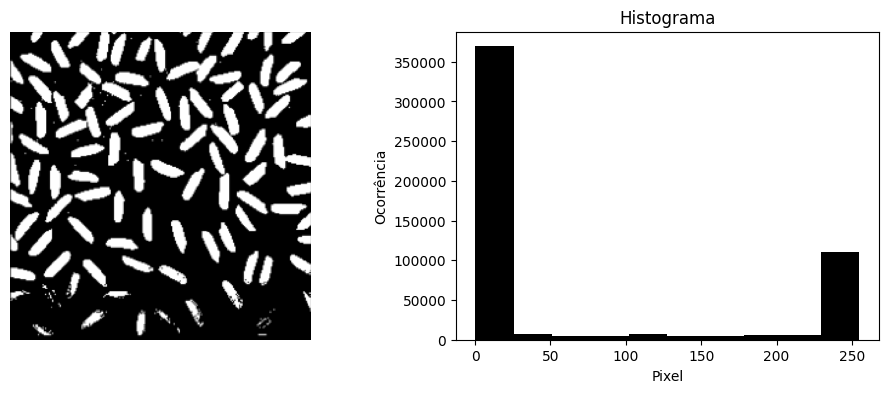

In [47]:
plot_image_and_histogram(image)

*  Para realizar a remoção do ruído, utilizou-se operações morfológicas, inicialmente, especificamente, a operação de abertura, composta por duas operações fundamentais: erosão seguida de dilatação.

* Aplicação da Erosão, a qual tem como objetivo reduzir  as bordas de objetos em uma imagem. Essa operacao  é bastante útil para remover esses pequenos elementos brancos, uma vez os objetos claros se tornarão menores e as regiões escuras aumentarão;

* Aplicação da Dilatação, a qual tem como objetivo dilatar as regioes de fronteira dos objetos, uma vez que os objetos escuros se tornarão menores e as regiões claras
aumentarão.

* Foram realizadas 5 iterações dessa operação. Além disso, ao final do processo, foi aplicada uma equalização de histograma na imagem, de modo a uniformizar a distribuição dos pixels.

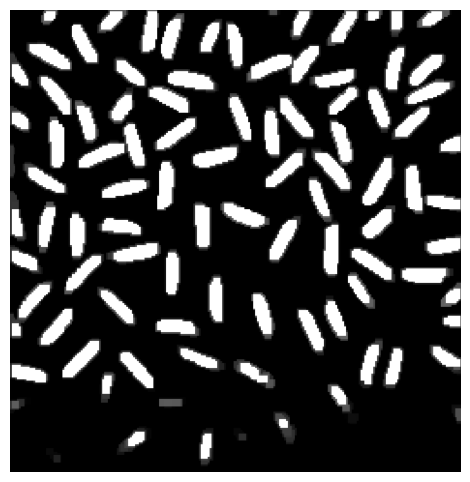

In [48]:
plot_image(remove_noise(image))

* O passo seguinte consistiu em limiarizar a imagem, uma vez que existem tons de cinza presentes na imagem. Para a realização do processo de contagem, é necessário que haja apenas dois tons de cores: neste caso, fundo (0) e objetos (255).

* Para realizar essa tarefa, foi utilizado o **Método de Otsu**, que permite encontrar o limiar ideal para o processo de binarização da imagem.

Otsu threshold: 100.0


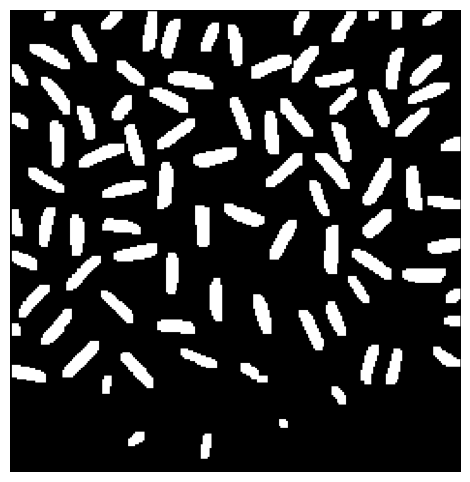

In [66]:
binary_image = otsu_threshold(remove_noise(image))
plot_image(binary_image)

* As operações morfológicas aplicadas e a remoção do ruído foram fundamentais para a separação dos objetos e, além disso, para a separação dos objetos que se tocam.

* A etapa seguinte consiste em percorrer a imagem e contar a quantidade de objetos presentes na imagem.

In [65]:
quantity_of_objects = count_objects(binary_image)
print("Quantidade de objetos econtrados:", quantity_of_objects)

Quantidade de objetos econtrados: 90


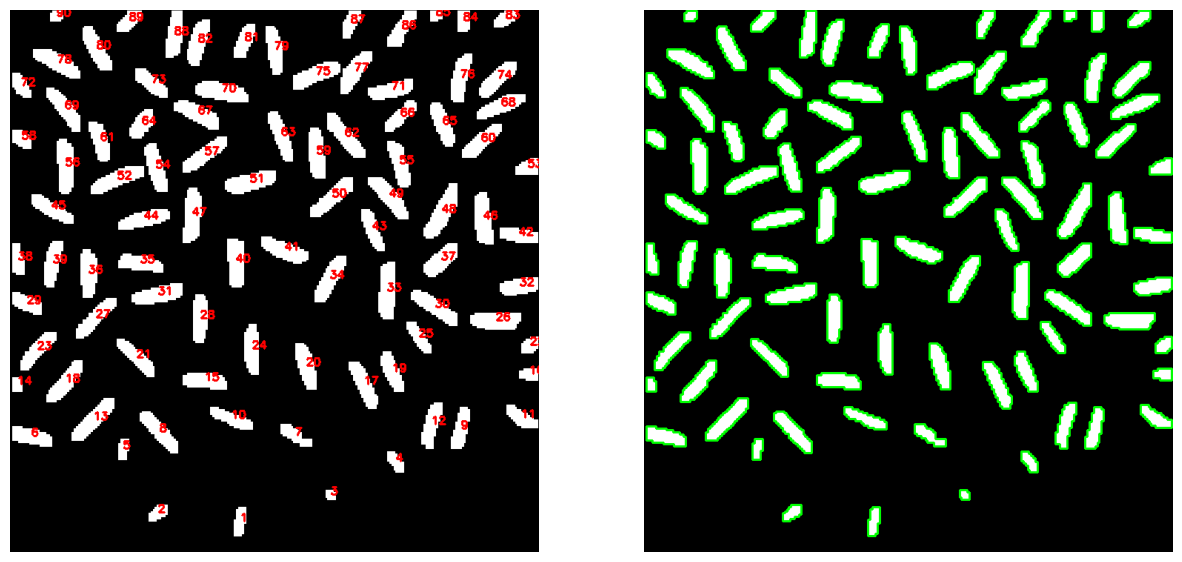

In [83]:
plot_two_images_side_by_side(get_annoted_objects(binary_image),get_image_on_contours(binary_image))

* Conforme é possível verificar, os objetos foram contabilizados com sucesso, não havendo duplicação de contagem em um mesmo objeto, nem dois objetos sendo contabilizados como um só.

* Uma outra abordagem possível seria utilizar o **Algoritmo de Watershed**. Esse algoritmo, utilizado para segmentação de imagens, pode ser empregado para contar a quantidade de objetos presentes na imagem, uma vez que ele segmenta a imagem em regiões distintas, separando objetos que inicialmente estão conectados.

* Ao segmentar a imagem e isolar os objetos, é possível contar o número de regiões ou componentes segmentados, o que corresponde ao número de objetos na imagem.

* Utilizando a imagem livre de ruído obtida anteriormente, o primeiro passo consiste na obtenção dos marcadores que servirão como base para a segmentação. Para isso, utiliza-se a **Transformada da Distância**, que calculará a distância de cada pixel até o objeto mais próximo.

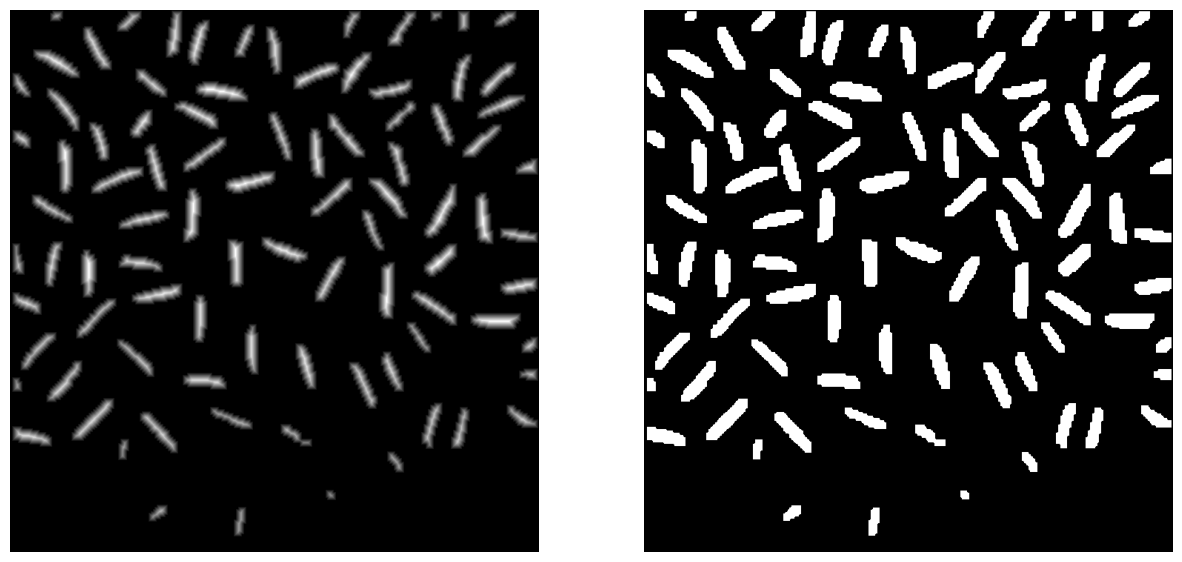

In [96]:
kernel=np.ones((3,3),np.uint8)
sure_bg = cv2.dilate(binary_image,kernel,iterations=1)
dist_transform = cv2.distanceTransform(binary_image,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

plot_two_images_side_by_side(dist_transform,cv2.cvtColor(sure_fg, cv2.COLOR_GRAY2RGB));

* A etapa seguinte consistiu na detecção dos componentes conectados no primeiro plano e os marcou com números inteiros diferentes.

* Por fim, aplicou-se o **Algoritmo de Watershed** para segmentar a imagem com base nos marcadores definidos.

In [ ]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(cv2.imread(path),markers)

In [97]:
print("Quantidade de objetos econtrados:", len(np.unique(markers)) - 2) # Remoção do fundo e das bordas da contagem

Quantidade de objetos econtrados: 90


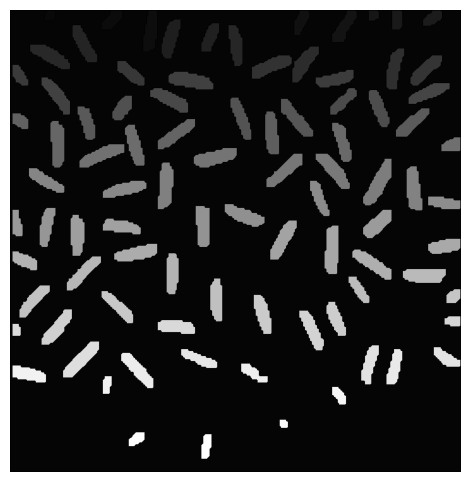

In [98]:
plot_image(markers)

* As duas abordagens utilizadas forneceram a mesma quantidade de objetos detectados; entretanto, objetos que estavam com sua forma corrompida foram interpretados como ruído e removidos durante o processo.

* Ambas as abordagens conseguiram evitar que objetos muito próximos fossem contabilizados como um só e também que um mesmo objeto fosse contabilizado como dois objetos. Esse sucesso se deve, principalmente, à aplicação das operações morfológicas.